import os
os.listdir(/-content)

In [1]:
import pandas as pd
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [3]:
df_model = df.drop(columns = ['UDI','Product ID','Type','Machine failure','TWF','HDF','PWF','OSF','RNF'])
df_model.columns
df_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)
X_scaled.shape

(10000, 5)

In [5]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
df_model['Anomaly IF'] = iso_forest.fit_predict(X_scaled)
df_model['Anomaly IF'].value_counts()


,count
Anomaly IF,
1,9500
-1,500


In [6]:
df_model.groupby('Anomaly IF').mean()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Anomaly IF,,,,,
-1,299.870200,309.788800,1803.944000,32.776200,98.970000
1,300.012021,310.016968,1524.819895,40.366421,108.423684


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_PCA= pca.fit_transform(X_scaled)
df_model['PCA1'] = X_PCA [:,0]
df_model['PCA2'] = X_PCA [:,1]

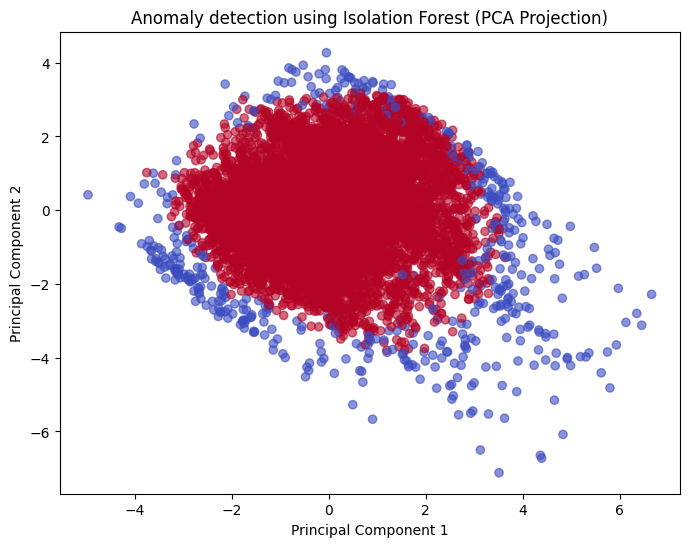

In [8]:
 import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter (
    df_model['PCA1'],
    df_model['PCA2'],
    c=df_model['Anomaly IF'],
    cmap='coolwarm',
    alpha=0.6
)
plt.title('Anomaly detection using Isolation Forest (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

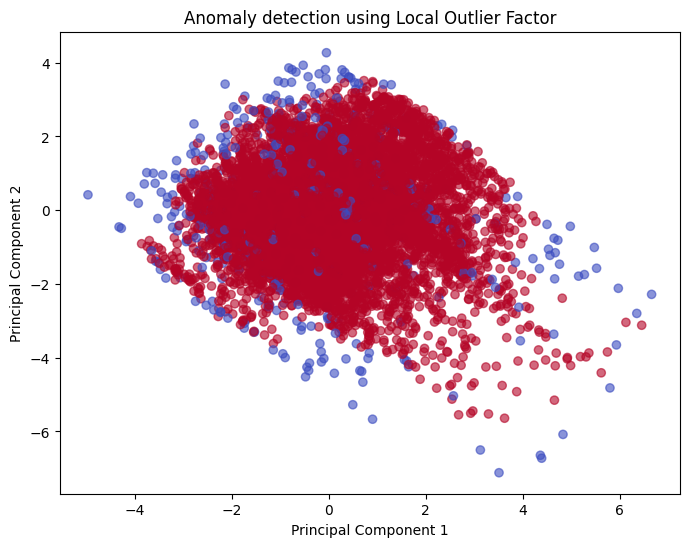

In [9]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_model['Anomaly LOF']= lof.fit_predict(X_scaled)


plt.figure(figsize=(8,6))
plt.scatter (
    df_model['PCA1'],
    df_model['PCA2'],
    c=df_model['Anomaly LOF'],
    cmap='coolwarm',
    alpha=0.6
)
plt.title('Anomaly detection using Local Outlier Factor')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [10]:
comparison = pd.DataFrame({
    'IsolationForest': df_model['Anomaly IF'].value_counts(),
    'LOF': df_model['Anomaly LOF'].value_counts()
})
comparison

,IsolationForest,LOF
1,9500,9500
-1,500,500


In [11]:
overlap = (
    (df_model['Anomaly IF'] == -1) &
    (df_model['Anomaly LOF'] == -1)
).sum()

overlap


np.int64(156)